In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import matplotlib.image as img
import numpy as np
import time
import math
from numpy import linalg as LA
from glob import glob


In [3]:
def read_all_images(path):
    """
    This function reads all the images and returns a image matrix
    """
    
    img_names = glob(path)
    img_list = []
    num_img = 0
    
    print('Image reading in progress, please wait...')
    
    for img_name in img_names:
        num_img = num_img + 1
        img_2d = img.imread(img_name, 0)
        temp = img_2d.flatten()
        # changing dimension of image from (N x N) to (N^2, 1)
        img_1d = temp.reshape(len(temp),1)

        # This if statement is included because it needs a shape of initial array
        if num_img == 1:
            img_list = img_1d
        else:
            # next img vector of (N^2, 1) is added horizontally to the img_list
            img_list = np.hstack((img_list, img_1d))        

    print("\n************ Image reading is Finished!!! ************")

    train_imgs = np.array(img_list)
            
    print("number of images read: %d"%num_img)
    print("shape of the image matrix: ", train_imgs.shape)
    
    return train_imgs

In [4]:
img_path = '/Users/inyeobkim/Desktop/FA19/cmsc426/kim8885_proj1/StarterFiles/Train1/*.jpg'

train_imgs = read_all_images(img_path)

Image reading in progress, please wait...

************ Image reading is Finished!!! ************
number of images read: 3772
shape of the image matrix:  (19500, 3772)


In [5]:
def center_img(imgs):
    """
    This function centers the image matrix
    """
    
    num_row = len(imgs)
    num_col = len(imgs[0])
    
    avg_face_vec = []
    
    # average face vector
    avg_face_vec = imgs.mean(axis=1)
    
    # subtracting the mean face (centered)
    ctd_imgs = imgs - avg_face_vec.reshape((num_row,1))

    return ctd_imgs

In [6]:
# Centering the training images
ctd_train_imgs = center_img(train_imgs)

In [7]:
def get_best_eig_vecs(ctd_train_imgs, target_var_percentage):
    """
    This function returns best K eigenvalues and eigenvectors that captures
    a certain variance percentage
    """
    
    # get eig vals of A.T.dot(A)
    print("Getting eigenvalues and eigenvectors that capture %d%% variance...\n"\
          %target_var_percentage)
    eig_vals, eig_vecs = LA.eig(ctd_train_imgs.T.dot(ctd_train_imgs))
    
    print('shape after centering = ', eig_vecs.shape)
    
    sum_eig_vals = np.sum(eig_vals)

    vc_percentage = 0.0 # variance capture percentage
    num_eig_vals = 0
    target_variance = target_var_percentage / 100.0

    # capturing a target variance
    for i in range(len(eig_vals)):
        if vc_percentage < target_variance:
            vc_percentage = vc_percentage + (eig_vals[i] / sum_eig_vals)
            num_eig_vals = num_eig_vals + 1
        else:
            break
    
    # picking the best K number of eigenvectors with respect to the
    # variance capture percentage
    best_eig_vals = eig_vals[0:num_eig_vals]
    
    # eigen vectors of A*A_T can be represented with A.dot(eigenvectors of A_T*A)
    best_eig_vecs = ctd_train_imgs.dot(eig_vecs[:, 0:num_eig_vals])
    
    print('best eig vec shape = ', best_eig_vecs.shape)
    # normalizing the eigenvectors
    best_eig_vecs_T = best_eig_vecs.T
    num_row = len(best_eig_vecs_T)
    num_col = len(best_eig_vecs_T[0])
    
    temp = np.sqrt(np.sum(np.square(best_eig_vecs_T), axis = 1))
    temp = temp.reshape((len(temp), 1))
    
    normalized_best_eig_vecs_T = best_eig_vecs_T / temp
    
    print("Variance capture percentage: %f%%"%(vc_percentage * 100))
    print("K = ", num_eig_vals)
    print('K best eigenvectors: \n', normalized_best_eig_vecs_T.T)
    
    return best_eig_vals, normalized_best_eig_vecs_T.T, (vc_percentage * 100)

In [10]:
best_eig_vals, best_eig_vecs, vc = get_best_eig_vecs(ctd_train_imgs, 45)
print(best_eig_vals)

Getting eigenvalues and eigenvectors that capture 45% variance...

shape after centering =  (3772, 3772)
best eig vec shape =  (19500, 7)
Variance capture percentage: 45.296911%
K =  7
K best eigenvectors: 
 [[ 2.84924670e-05  2.89520239e-05  1.28034956e-04 ...  2.11947465e-06
  -3.67717201e-05  5.89006267e-05]
 [-1.75881945e-04 -1.99725306e-04 -1.89706620e-04 ...  1.31140458e-04
   1.68040617e-04  1.08397078e-04]
 [-1.03921376e-04 -9.43555275e-05  2.87133738e-05 ...  7.39265089e-05
  -1.07729929e-05  1.02143307e-04]
 ...
 [-3.07412973e-06 -2.29153526e-06  4.13601008e-05 ...  1.04959578e-05
  -5.40798046e-05  5.40590294e-05]
 [-3.07412973e-06 -2.29153526e-06  4.13601008e-05 ...  1.04959578e-05
  -5.40798046e-05  5.40590294e-05]
 [-3.07412973e-06 -2.29153526e-06  4.13601008e-05 ...  1.04959578e-05
  -5.40798046e-05  5.40590294e-05]]
[3.01853707e+10 2.56165913e+10 1.24712773e+10 1.04332252e+10
 8.03585582e+09 6.90323788e+09 5.84675452e+09]


In [16]:
print(best_eig_vecs.shape)

(19500, 676)


In [17]:
def project_img(imgs, best_eig_vecs):
    """
    This function returns a projected images based on the best K eigenvectors
    """
    
    img_coefs = best_eig_vecs.T.dot(imgs)
    
    projected_imgs = best_eig_vecs.dot(img_coefs)
    
    print('Shape of img_coefs')
    print(img_coefs.shape)
    print('Shape of projected_imgs')
    print(projected_imgs.shape)
    
    return img_coefs, projected_imgs


In [24]:
# Getting projected training images
projected_img_coefs, projected_train_imgs = project_img(ctd_train_imgs, best_eig_vecs)

print('Train images projected!')

Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Train images projected!


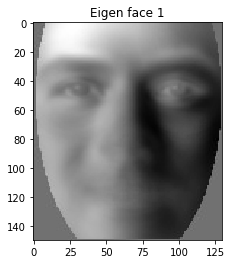

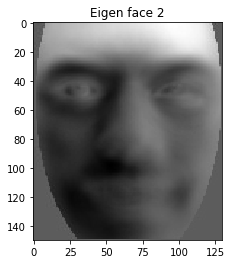

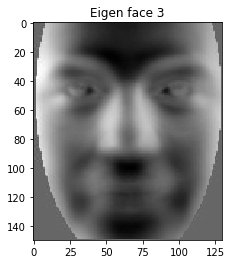

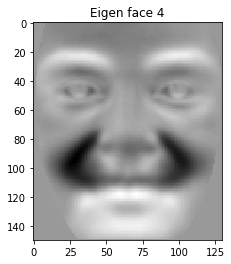

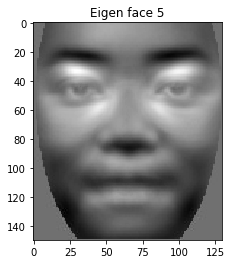

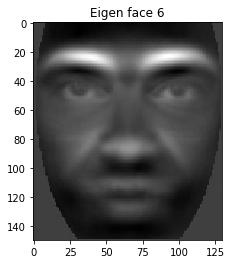

In [17]:
# Displaying eigenfaces
eig_face0 = best_eig_vecs[:, 0]
eig_face1 = best_eig_vecs[:, 1]
eig_face2 = best_eig_vecs[:, 2]
eig_face3 = best_eig_vecs[:, 3]
eig_face4 = best_eig_vecs[:, 4]
eig_face5 = best_eig_vecs[:, 5]

plt.imshow(eig_face0.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 1')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(eig_face1.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 2')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(eig_face2.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 3')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(eig_face3.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 4')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(eig_face4.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 5')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(eig_face5.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Eigen face 6')
plt.gray()  #grayscale conversion
plt.show()


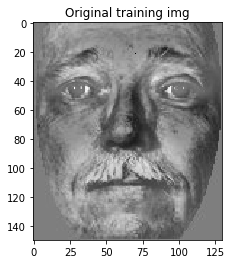

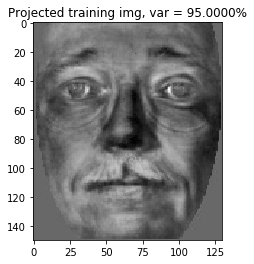

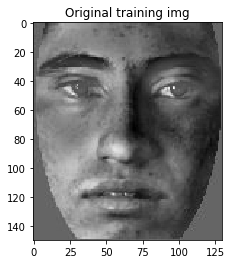

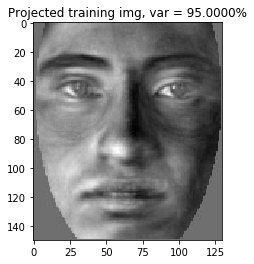

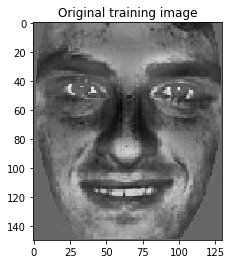

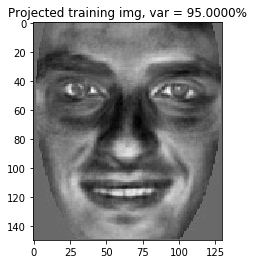

In [18]:
# Displaying 3 examples of faces represted as a linear combination
# of the K eigenvectors and compare it with the original image

img0 = ctd_train_imgs[:, 0].reshape((19500,1))
img1 = ctd_train_imgs[:, 10].reshape((19500,1))
img2 = ctd_train_imgs[:, 100].reshape((19500,1))

plt.imshow(img0.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Original training img')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(projected_train_imgs[:, 0].reshape((19500, 1)).reshape((150,130)), \
           interpolation='nearest') #display the image 
plt.title('Projected training img, var = %.4f%%'%vc)
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(img1.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Original training img')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(projected_train_imgs[:, 10].reshape((19500, 1)).reshape((150,130)), \
           interpolation='nearest') #display the image 
plt.title('Projected training img, var = %.4f%%'%vc)
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(img2.reshape((19500, 1)).reshape((150,130)), interpolation='nearest')
plt.title('Original training image')
plt.gray()  #grayscale conversion
plt.show()

plt.imshow(projected_train_imgs[:, 100].reshape((19500, 1)).reshape((150,130)), \
           interpolation='nearest') #display the image 
plt.title('Projected training img, var = %.4f%%'%vc)
plt.gray()  #grayscale conversion
plt.show()

In [18]:
# Using Test set of images

test_img_path = '/Users/inyeobkim/Desktop/FA19/cmsc426/kim8885_proj1/StarterFiles/Test1/*.jpg'

test_imgs = read_all_images(test_img_path)

Image reading in progress, please wait...

************ Image reading is Finished!!! ************
number of images read: 44
shape of the image matrix:  (19500, 44)


In [19]:
# centering the test image matrix
ctd_test_imgs = center_img(test_imgs)
print('images centered!')

images centered!


In [20]:
def find_closest_img(test_img, ctd_train_imgs, best_eig_vecs):

    proj_train_imgs_coefs, proj_train_imgs = project_img(ctd_train_imgs, best_eig_vecs)
    proj_test_img_coefs, proj_test_img = project_img(test_img, best_eig_vecs)
    
    # get transposes for easier processing
    proj_test_img_T = proj_test_img.T
    proj_train_imgs_T = proj_train_imgs.T
    ctd_train_imgs_T = ctd_train_imgs.T
    
    print('projected test images shape', proj_test_img.shape)
    
    # get error
    ed = np.sqrt(np.sum(np.square(proj_test_img_T - proj_train_imgs_T), axis = 1))
    min_ed = min(ed)
    min_index = np.argmin(ed)
    
    closest_img = ctd_train_imgs_T[min_index]
    
    plt.imshow(test_img.reshape((19500, 1)).reshape((150,130)), interpolation='nearest') #display the image 
    plt.title('test image')
    plt.gray()  #grayscale conversion
    plt.show()
    
    plt.imshow(closest_img.reshape((19500, 1)).reshape((150,130)), interpolation='nearest') #display the image 
    plt.title('closest training image')
    plt.gray()  #grayscale conversion
    plt.show()
    
    print('minimum distance: ', min_ed)
    print('index for the min distance: ', min_index)

Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


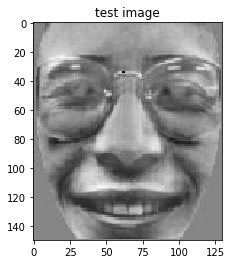

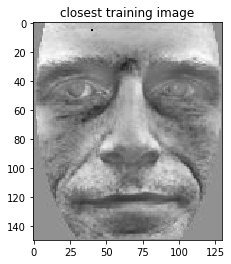

minimum distance:  6385.344590014775
index for the min distance:  3371
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


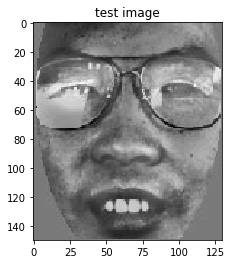

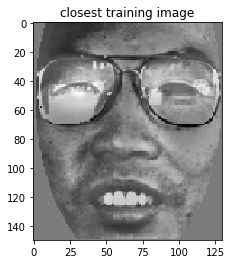

minimum distance:  6664.5591396442915
index for the min distance:  963
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


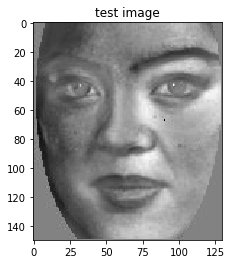

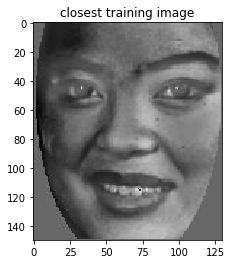

minimum distance:  4374.175943666676
index for the min distance:  1349
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


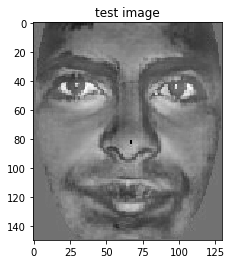

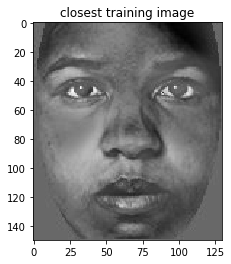

minimum distance:  5974.629293265038
index for the min distance:  2281
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


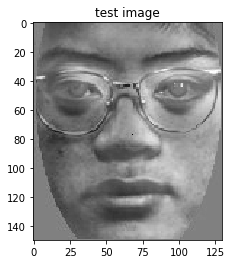

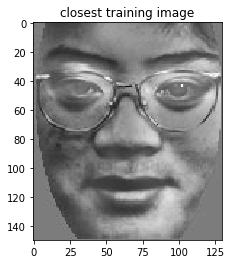

minimum distance:  5135.051924698312
index for the min distance:  507
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


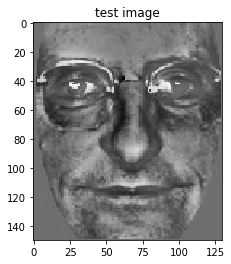

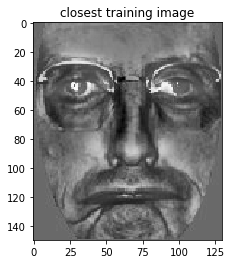

minimum distance:  4908.282705660068
index for the min distance:  485
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


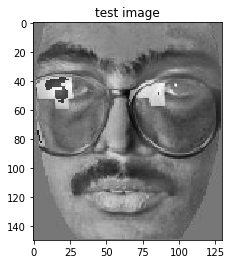

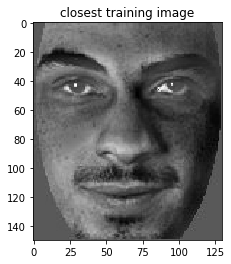

minimum distance:  7148.212498792706
index for the min distance:  3142
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


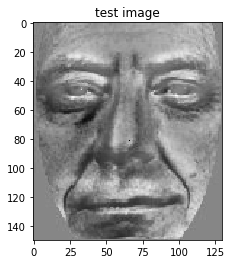

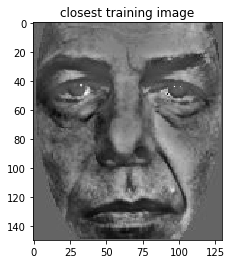

minimum distance:  6389.477832071455
index for the min distance:  1679
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


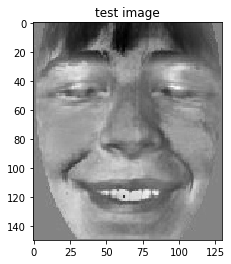

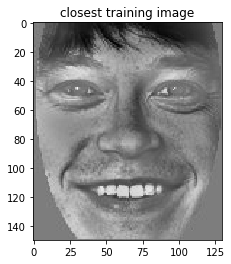

minimum distance:  6332.346192307551
index for the min distance:  3326
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


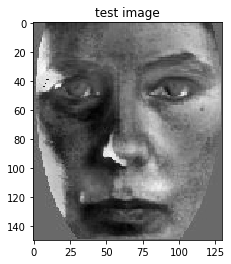

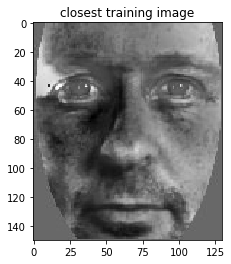

minimum distance:  6605.132005293084
index for the min distance:  222
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


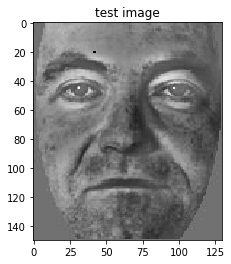

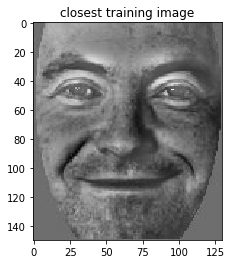

minimum distance:  4480.290345920571
index for the min distance:  2642
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


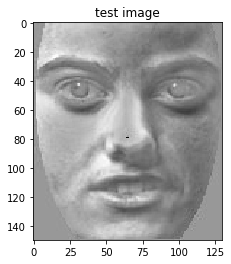

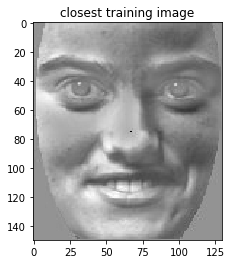

minimum distance:  3899.0782006492523
index for the min distance:  11
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


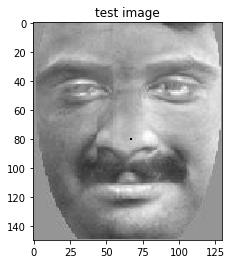

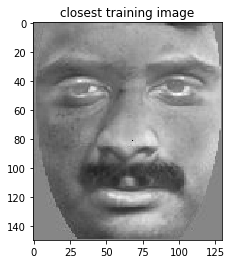

minimum distance:  4581.7554153472565
index for the min distance:  231
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


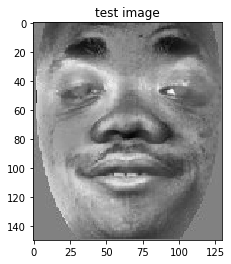

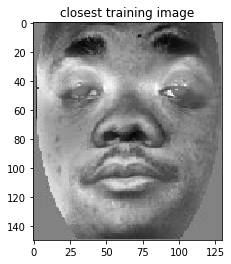

minimum distance:  4113.5809793949165
index for the min distance:  227
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


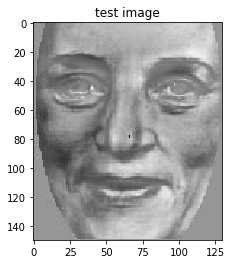

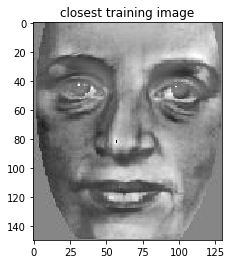

minimum distance:  4691.595328802734
index for the min distance:  214
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


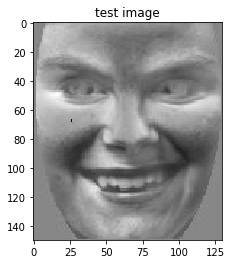

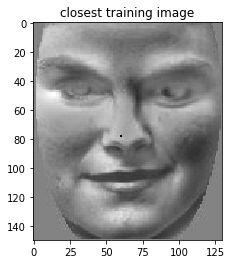

minimum distance:  5079.9089415225835
index for the min distance:  1682
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


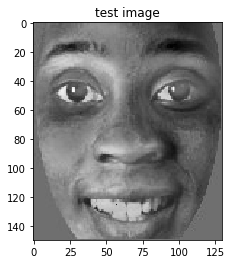

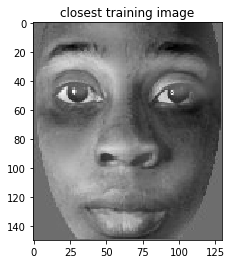

minimum distance:  4528.725655500815
index for the min distance:  294
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


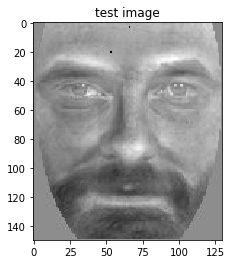

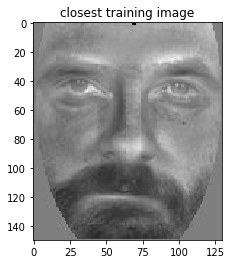

minimum distance:  3054.0483112947927
index for the min distance:  1327
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


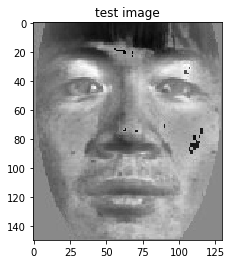

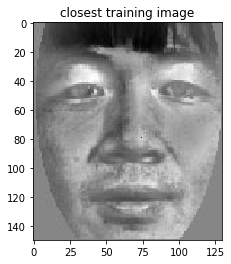

minimum distance:  5327.632287049244
index for the min distance:  1302
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


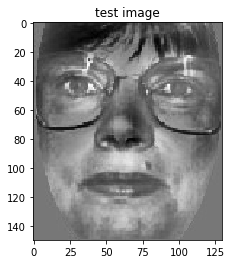

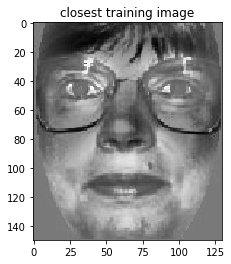

minimum distance:  3313.0573571412765
index for the min distance:  1380
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


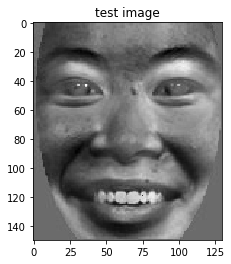

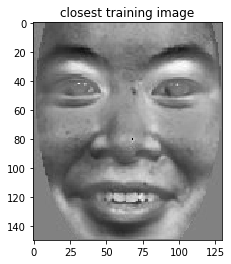

minimum distance:  2957.4989383617612
index for the min distance:  975
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


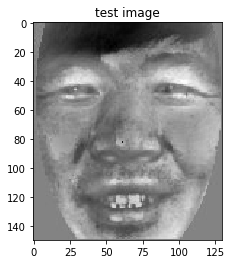

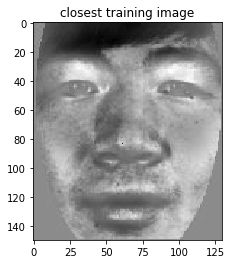

minimum distance:  5301.532864806519
index for the min distance:  872
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


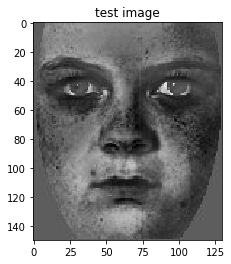

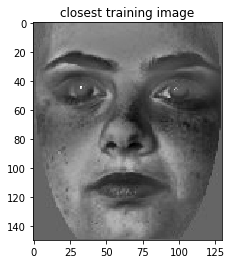

minimum distance:  4595.810992396426
index for the min distance:  1124
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


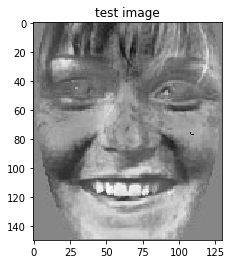

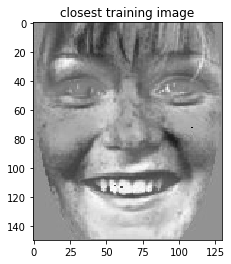

minimum distance:  4878.861998945129
index for the min distance:  2677
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


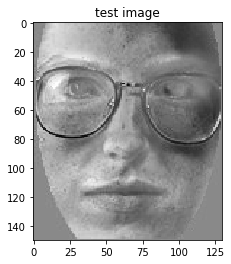

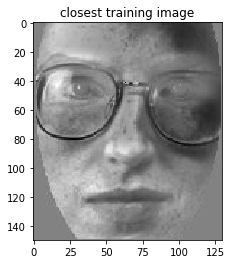

minimum distance:  4249.847254723182
index for the min distance:  2924
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


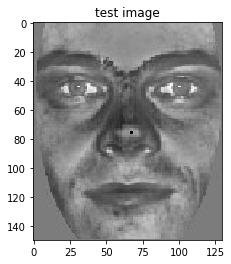

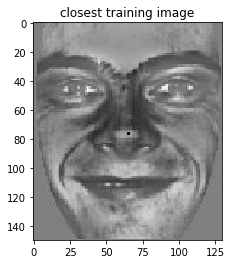

minimum distance:  5724.477326125366
index for the min distance:  2800
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


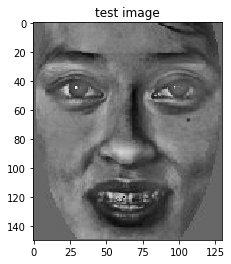

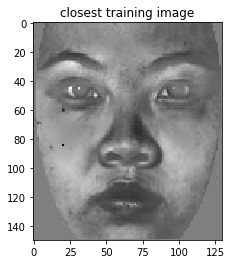

minimum distance:  5504.1899293386905
index for the min distance:  2591
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


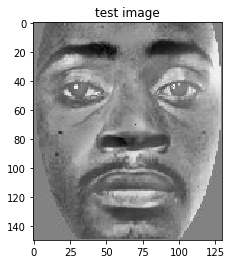

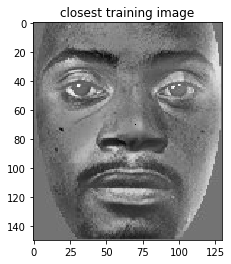

minimum distance:  5833.421470271248
index for the min distance:  130
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


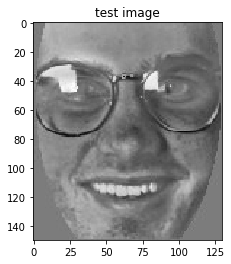

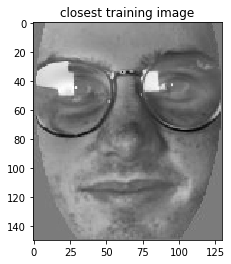

minimum distance:  5365.408368285064
index for the min distance:  3428
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


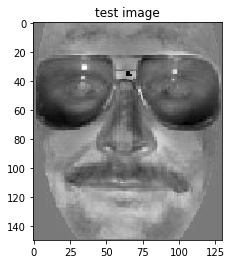

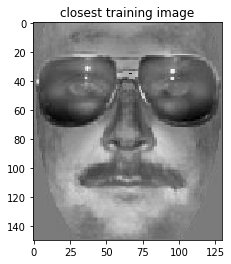

minimum distance:  3816.1858844976473
index for the min distance:  2209
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


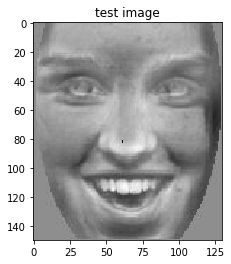

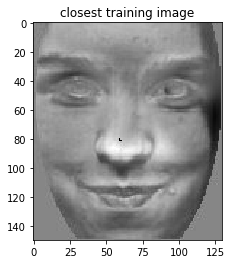

minimum distance:  4786.313613470532
index for the min distance:  2179
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


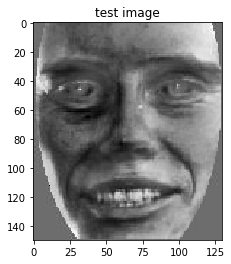

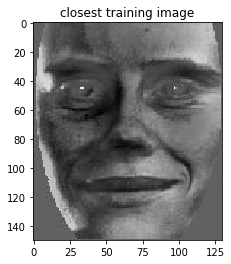

minimum distance:  4688.637604479125
index for the min distance:  3468
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


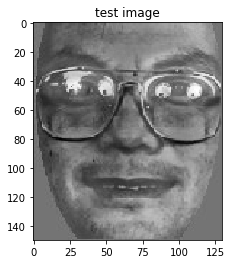

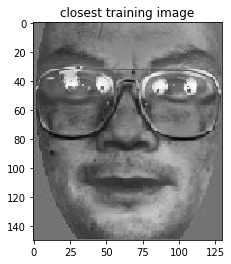

minimum distance:  5213.260414825329
index for the min distance:  2235
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


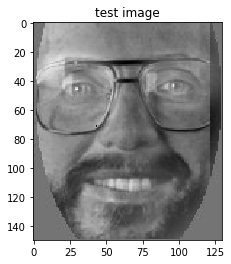

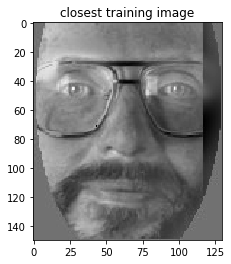

minimum distance:  5221.973739298606
index for the min distance:  3708
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


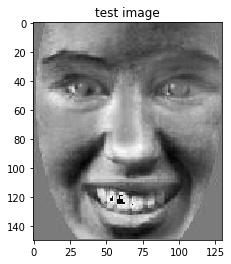

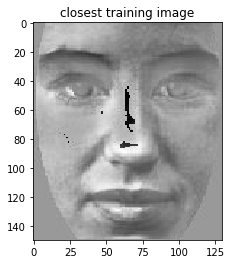

minimum distance:  6007.258932968454
index for the min distance:  1988
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


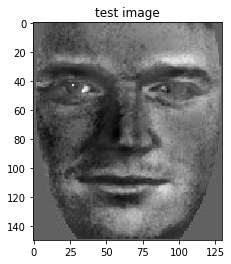

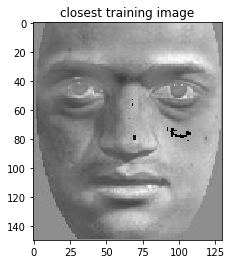

minimum distance:  5789.928609373982
index for the min distance:  2540
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


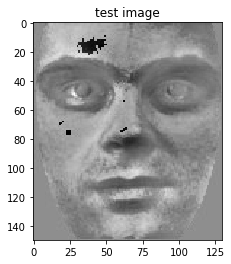

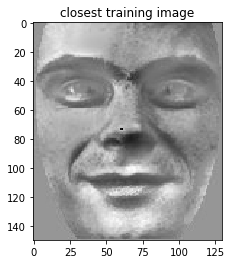

minimum distance:  4878.832549595617
index for the min distance:  3564
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


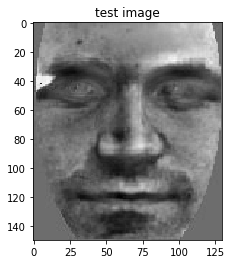

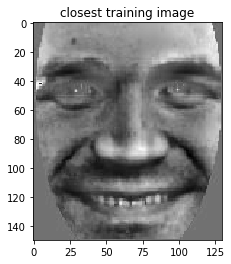

minimum distance:  5136.611057000655
index for the min distance:  1990
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


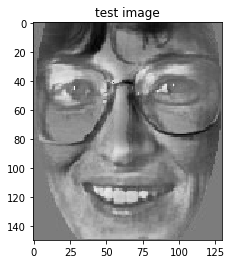

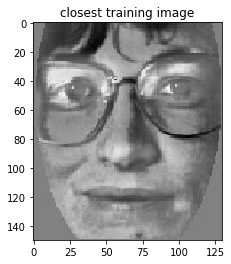

minimum distance:  5583.289179450771
index for the min distance:  1928
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


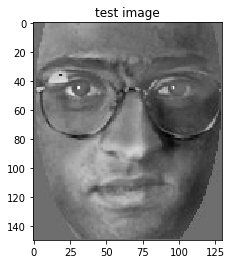

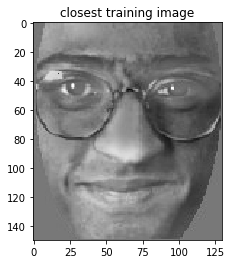

minimum distance:  4291.701146942682
index for the min distance:  2328
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


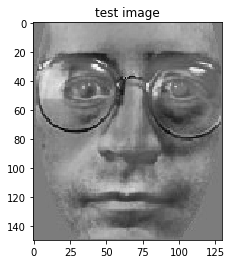

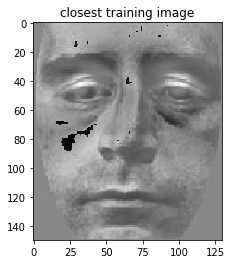

minimum distance:  5766.577360701658
index for the min distance:  737
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


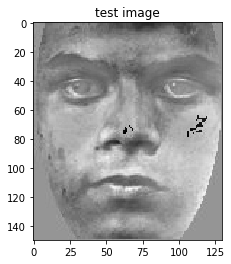

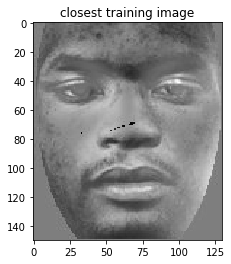

minimum distance:  5605.341720925141
index for the min distance:  3305
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


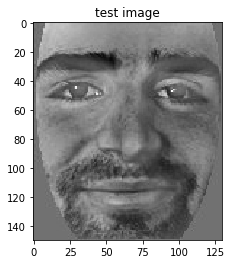

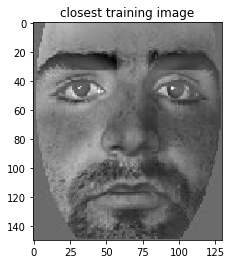

minimum distance:  4600.027094286816
index for the min distance:  1673
Shape of img_coefs
(676, 3772)
Shape of projected_imgs
(19500, 3772)
Shape of img_coefs
(676,)
Shape of projected_imgs
(19500,)
projected test images shape (19500,)


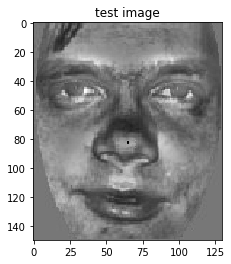

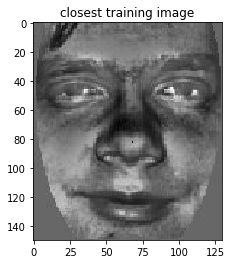

minimum distance:  4772.6197703096595
index for the min distance:  2889


In [24]:
# test_img = ctd_train_imgs[:, 10]

for i in range(0,44):
    test_img = ctd_test_imgs[:, i]
    find_closest_img(test_img, ctd_train_imgs, best_eig_vecs)


In [23]:
a = np.array([[1,2],
             [0,0]])

b = np.array([[3,4],
             [2,1]])

print(a.dot(b))
print(a @ b)

[[7 6]
 [0 0]]
[[7 6]
 [0 0]]
